
# Attention & Transformers

**Levels**
1. Attention intuition with a toy example and heatmap
2. Self-attention inside a Transformer encoder (BERT) — visualize attention
3. Attention in action: summarization and a quick Vision Transformer map

## Setup — run once

In [1]:

# If needed, uncomment to install
%pip install -q torch torchvision torchaudio transformers matplotlib pillow numpy requests



## Level 1 — *Where should the model look?* (Toy Attention)
Visualize scaled dot-product attention weights for the pronoun **"it"**.


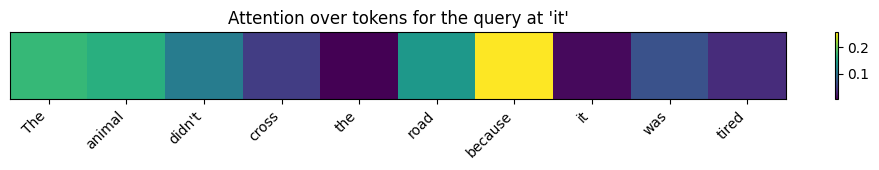

In [4]:

import numpy as np
import matplotlib.pyplot as plt

tokens = ["The","animal","didn't","cross","the","road","because","it","was","narrow"]

np.random.seed(0)
d = 4
Q = np.random.randn(1, d)          # query for "it"
K = np.random.randn(len(tokens), d) # keys for all tokens

scale = np.sqrt(d)
scores = (Q @ K.T) / scale
weights = np.exp(scores - scores.max())
weights = weights / weights.sum()

plt.figure(figsize=(10, 1.8))
plt.imshow(weights, aspect="auto")
plt.yticks([])
plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
plt.title("Attention over tokens for the query at 'it'")
plt.colorbar()
plt.tight_layout()
plt.show()



### Exercise 1 (2 pts)
Edit the sentence so **"it"** refers to **"road"** (not **"animal"**). Re-run the plot cell and observe attention shift.


In [5]:

# YOUR TURN: Modify 'tokens' and re-run the plot cell above.
tokens = ["The","animal","didn't","cross","the","road","because","it","was","narrow"]
pass


In [6]:

# (Graded sanity check 2 pts)
assert isinstance(tokens, list) and all(isinstance(t, str) for t in tokens)



## Level 2 — Self-Attention in BERT (Encoder)
We visualize the last layer's attention for a sentence (downloads model on first run).


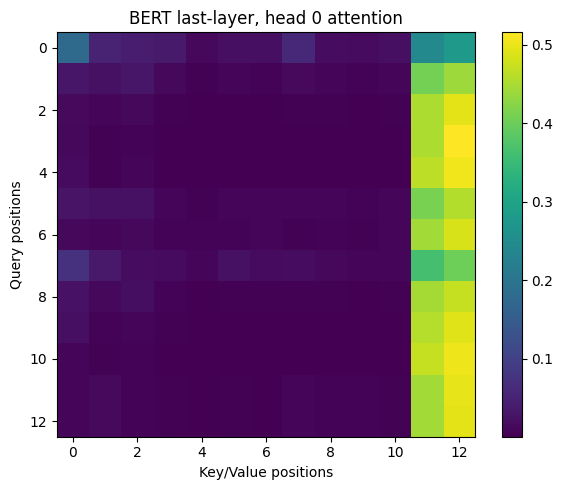

Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', 'because', 'it', 'was', 'gross', '.', '[SEP]']


In [19]:

import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True).to(device)

sentence = "The cat sat on the mat because it was gross."
inputs = tokenizer(sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions  # (layers, batch, heads, seq, seq)
last = attentions[-1][0]         # (heads, seq, seq)
head0 = last[0].cpu().numpy()

plt.figure(figsize=(6,5))
plt.imshow(head0, aspect="auto")
plt.title("BERT last-layer, head 0 attention")
plt.xlabel("Key/Value positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.tight_layout()
plt.show()

print("Tokens:", tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))



### Exercise 2 (4 pts)
Change the sentence so **"it"** refers to **"mat"** (not **"cat"**), then re-run the visualization.
Describe what changes in the attention (2–4 sentences) below.


With the orignal "tired" prompt I saw that the Key/Value position of 12 was a lot more green or ~0.4 then in trying other words that should imply the mat instead of the cat it did change. "cold" for example lightened it up a bit but could still imply the cat. "wet" got even lighter and "gross" was the most interesting since it almost could not be misstaken for the cat, I did notice that basicly the last two Key/Value position colors 11 & 12 swaped compared to the original yellow&green to green&yellow.

In [20]:

# Auto-check heuristic (4 pts): encourage both 'mat' and 'cat' in sentence.
text = sentence.lower()
score = 0
if "mat" in text: score += 2
if "cat" in text: score += 2
print("Auto-score suggestion (out of 4):", score)


Auto-score suggestion (out of 4): 4



## Level 3 — Applications
### A) Summarization


In [44]:

from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
text = (
    "Transformers enable parallel sequence processing through self-attention, capturing long-range "
    "dependencies and benefiting large-scale pretraining. This has led to major improvements in tasks "
    "like machine translation, summarization, and question answering."
)
# print(summarizer(text, max_length=30, min_length=15, do_sample=False)[0]['summary_text'])
print(summarizer(text, max_length=24, min_length=12, do_sample=False)[0]['summary_text'])


Device set to use cpu


Transformers enable parallel sequence processing through self-attention. This has led to major improvements in tasks like



### B) Vision Transformer — CLS→patch attention map


In [22]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import ViTFeatureExtractor, ViTModel


In [35]:
url = "https://static.wikia.nocookie.net/89eae11d-79d3-421f-ae61-c134ebf037c0/scale-to-width/755"
img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
# img = Image.open(url).convert("RGB")


In [36]:
extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224", output_attentions=True)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
inputs = extractor(images=img, return_tensors="pt")
with torch.no_grad():
    out = model(**inputs)


In [38]:
attn = out.attentions[-1][0,0]  # (seq, seq)
cls_to_patches = attn[0,1:].numpy()
side = int(np.sqrt(cls_to_patches.shape[0]))
heat = cls_to_patches.reshape(side, side)


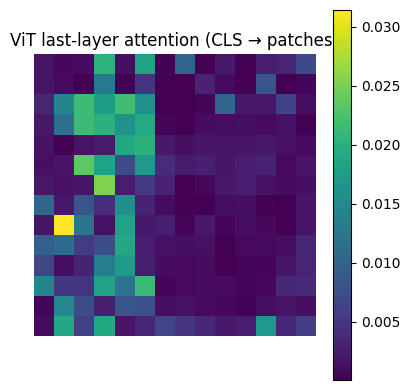

In [39]:
plt.figure(figsize=(4,4))
plt.imshow(heat)
plt.title("ViT last-layer attention (CLS → patches)")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()



## Reflection (2 pts)
Explain how attention differs from RNN-style context handling and why transformer parallelism matters (3–5 sentences).


The main difference would be in how the two handle context. RNN relies on sequential handling of the context while Attention handles all the context all to together at the same time. This concurrent handling allows transformers to run in parallel which is how we make use of modern hardware. It allows us to overcome previous limits of single GPUs and now we are able to tackle massive models as well because of this. In contrast RNNs are slower, not as good at tracking context, and lack scalibility.